In [1]:
import os, math
from collections import defaultdict, namedtuple
import itertools
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *
import cortical_column_host as ccp

In [2]:
DF_TEST_RESULTS = pd.DataFrame(columns=['test_run_id', 'config_variant', 'cortical_columns', 'train_images_count', 'train_runs',
                                        'source_ds', 'test_image_id', 'true_value', 'infer_value', 'sim'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [3]:
LOG = Logging()

config_var = 'SQLITE3_EXNORMAL_GRID_RADIAL_7_256'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
print(f'xp = {xp.__name__}')

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name))
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name))

mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, fork method leads to failures in bootstrap somewhere around CUDA

xp = cupy


In [4]:
hdc = Hdc(10_000, xp)

In [5]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 9 μs, sys: 1e+03 ns, total: 10 μs
Wall time: 18.8 μs


((10000, 3), (2000, 3))


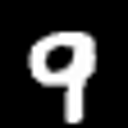
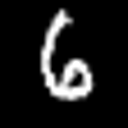
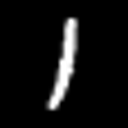
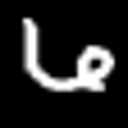
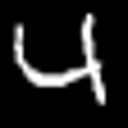
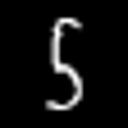
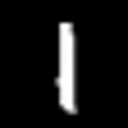
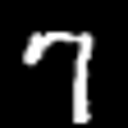
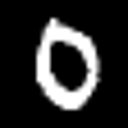
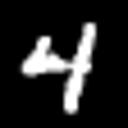
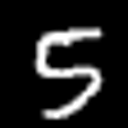
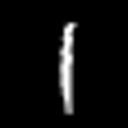
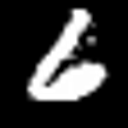
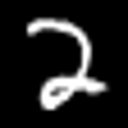
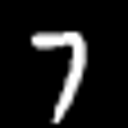
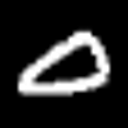

In [6]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [7]:
class CorticalColumnHost(object):
    task_id = 0
    
    def __init__(self, host_id, column_ids):
        self.host_id = host_id
        self.column_ids = column_ids
        self.task_queue = mp_ctx.Queue()
        self.result_queue = mp_ctx.Queue()
        self.process = mp_ctx.Process(target=ccp.live, args=(config.section_name, host_id, column_ids, self.task_queue, self.result_queue))
        self.process.start()

    @staticmethod
    def gen_task_id():
        CorticalColumnHost.task_id += 1
        return CorticalColumnHost.task_id

    def healthcheck(self):
        task = ccp.Task(task_id=self.gen_task_id(), op='HEALTHCHECK')
        self.task_queue.put(task)
        self.result_queue.get()
        
    def terminate(self):
        task = ccp.Task(task_id=self.gen_task_id(), op='TERMINATE')
        self.task_queue.put(task)
        self.result_queue.get()
        self.process.join()

    def train_start(self, train_run_id, image_ids, consolidation_threshold, attempts_to_get_no_mistakes):
        task = ccp.Task(task_id=self.gen_task_id(), 
                        op='TRAIN', 
                        params={'train_run_id': train_run_id, 
                                'image_ids': image_ids, 
                                'consolidation_threshold': consolidation_threshold, 
                                'attempts_to_get_no_mistakes': attempts_to_get_no_mistakes})
        self.task_queue.put(task)

    def train_finish(self):
        self.result_queue.get()

    def infer_start(self, image_id, dataset_name):
        task = ccp.Task(task_id=self.gen_task_id(), op='INFER', params={'dataset_name': dataset_name, 'image_id': image_id})
        self.task_queue.put(task)

    def infer_finish(self):
        task_result = self.result_queue.get()
        assert not task_result.payload is None
        return task_result.payload['column_votes_vector'], task_result.payload['column_images_seen']

In [8]:
if 'COLUMN_HOSTS' in globals():
    for column_host in COLUMN_HOSTS.values():
        column_host.terminate()    
        print(f'Column host {column_host.host_id} terminated')

# columns_to_launch = range(0, config.cortical_columns_count)
columns_to_launch = range(-1, config.cortical_columns_count)
COLUMN_HOSTS = dict(map(lambda i: (i, CorticalColumnHost(i, [i])), columns_to_launch))

for column_host in COLUMN_HOSTS.values():
    column_host.healthcheck()
    print(f'Column host {column_host.host_id} is ready')

Column host -1 is ready
Column host 0 is ready
Column host 1 is ready
Column host 2 is ready
Column host 3 is ready
Column host 4 is ready
Column host 5 is ready
Column host 6 is ready


In [16]:
%%time

train_runs = 50
attempts_to_get_no_mistakes = 10
count = min(1000, len(df_train_images))
consolidation_threshold = 1000

for _ in tqdm(range(train_runs)):
    TRAIN_RUN_ID += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    
    for column_id, column in COLUMN_HOSTS.items():
        column.train_start(TRAIN_RUN_ID, image_ids, consolidation_threshold, attempts_to_get_no_mistakes)

    for column_id, column in COLUMN_HOSTS.items():
        column.train_finish()

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 557 ms, sys: 309 ms, total: 867 ms
Wall time: 23min 19s


In [58]:
def softmax(x):
    max_x = np.max(x)
    exp_x = np.exp(x - max_x)
    sum_exp_x = np.sum(exp_x)
    return exp_x / sum_exp_x

def conflate(pdfs):    
    n = np.prod(pdfs, axis=0)
    d = n.sum()

    if np.isclose(d, 0):
        return np.zeros(len(pdfs))
        
    return n / d

In [ ]:
# TEST RUN
TEST_RUN_ID += 1
test_run_source = (df_test_images, test_db_con, 'test')
# test_run_source = (df_train_images, train_db_con, 'train')
count = min(2000, len(test_run_source[0]))
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
# test_image_ids = image_ids
test_result_rows = defaultdict(list)
column_id_whitelist = COLUMN_HOSTS.keys()
# column_id_whitelist = [3]
assert np.all(np.array(list(map(lambda i: i in COLUMN_HOSTS, column_id_whitelist))) == 1)

for image_id in tqdm(test_image_ids):
    image_value = test_run_source[0].loc[image_id]['value']
    column_votes_vector = np.zeros(10)
    column_images_seen = {}
    
    for column_id, column_host in COLUMN_HOSTS.items():
        if not column_id in column_id_whitelist:
            continue

        column_host.infer_start(image_id, test_run_source[2])

    for column_id, column_host in COLUMN_HOSTS.items():
        if not column_id in column_id_whitelist:
            continue

        column_votes_vector_, column_images_seen_ = column_host.infer_finish()
        column_votes_vector += column_votes_vector_
        column_images_seen.update(column_images_seen_)

    infer_value = ''
    
    if np.any(column_votes_vector) > 0:
        # digit_probabilities = softmax(column_votes_vector)
        # infer_value = str(RNG.choice(10, p=digit_probabilities))
        infer_value = str(np.argmax(column_votes_vector)) # softmax([0,0,0,0,0,0,0,0,0,4]) will produce probs [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.9]
    
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append(sorted(column_id_whitelist))
    test_result_rows['train_images_count'].append(max(list(column_images_seen.values())))
    test_result_rows['train_runs'].append(TRAIN_RUN_ID)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['infer_value'].append(infer_value) 
    test_result_rows['sim'].append(column_votes_vector)
    

assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns), set(test_result_rows.keys()) ^ set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

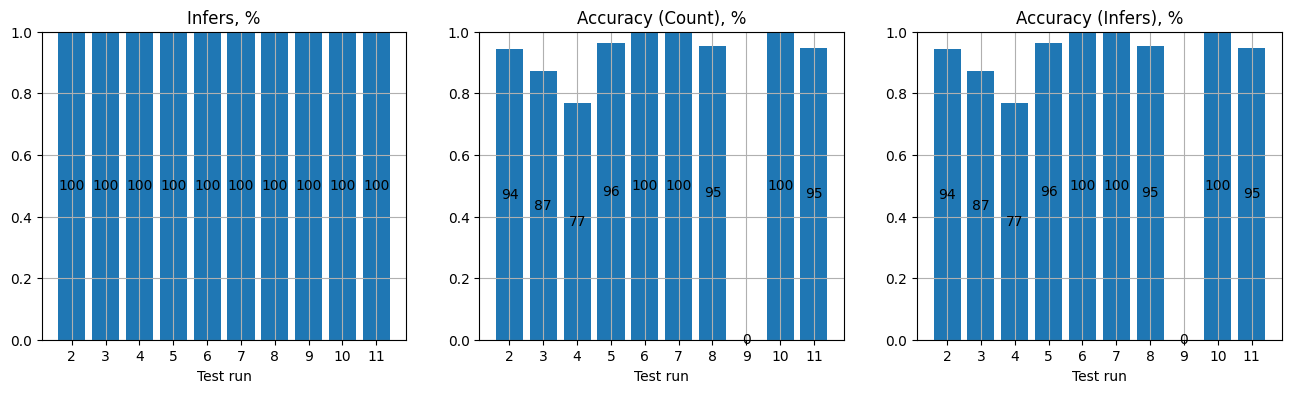

,config_variant,source_ds,cortical_columns,train_images_count,train_runs,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,,
2,SQLITE3_EXNORMAL_GRID_RADIAL_7_256,train,"[-1, 0, 1, 2, 3, 4, 5, 6]",2528,1,1000,1000,945,1.0,0.9450,0.9450
3,SQLITE3_EXNORMAL_GRID_RADIAL_7_256,train,"[-1, 0, 1, 2, 3, 4, 5, 6]",64048,51,2000,2000,1744,1.0,0.8720,0.8720
4,SQLITE3_EXNORMAL_GRID_RADIAL_7_256,test,"[-1, 0, 1, 2, 3, 4, 5, 6]",64048,51,2000,2000,1540,1.0,0.7700,0.7700
5,SQLITE3_EXNORMAL_GRID_RADIAL_7_256,train,"[-1, 0, 1, 2, 3, 4, 5, 6]",64048,51,1000,1000,963,1.0,0.9630,0.9630
6,SQLITE3_EXNORMAL_GRID_RADIAL_7_256,train,"[-1, 0, 1, 2, 3, 4, 5, 6]",64048,51,1,1,1,1.0,1.0000,1.0000
7,SQLITE3_EXNORMAL_GRID_RADIAL_7_256,train,"[-1, 0, 1, 2, 3, 4, 5, 6]",64048,51,2,2,2,1.0,1.0000,1.0000
8,SQLITE3_EXNORMAL_GRID_RADIAL_7_256,train,"[-1, 0, 1, 2, 3, 4, 5, 6]",64048,51,1000,1000,954,1.0,0.9540,0.9540
9,SQLITE3_EXNORMAL_GRID_RADIAL_7_256,train,"[-1, 0, 1, 2, 3, 4, 5, 6]",64048,51,1000,1000,0,1.0,0.0000,0.0000
10,SQLITE3_EXNORMAL_GRID_RADIAL_7_256,train,"[-1, 0, 1, 2, 3, 4, 5, 6]",64048,51,1000,1000,1000,1.0,1.0000,1.0000


In [65]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2